In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from loadData import allData 

# Assume allData is already loaded from loadData.py
# Select only numeric columns for PCA (excluding category columns if you want to color by them)
numeric_cols = allData.select_dtypes(include=[np.number]).columns
X = allData[numeric_cols].drop(['country', 'text', 'answer','economic_category', 'geographical_category', 'educational_category'], axis=1, errors='ignore')

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

Explained variance ratio: [0.19460895 0.13464535]
Total explained variance (first 2 PCs): 0.32925430265640626
Number of components for at least 80% explained variance: 13


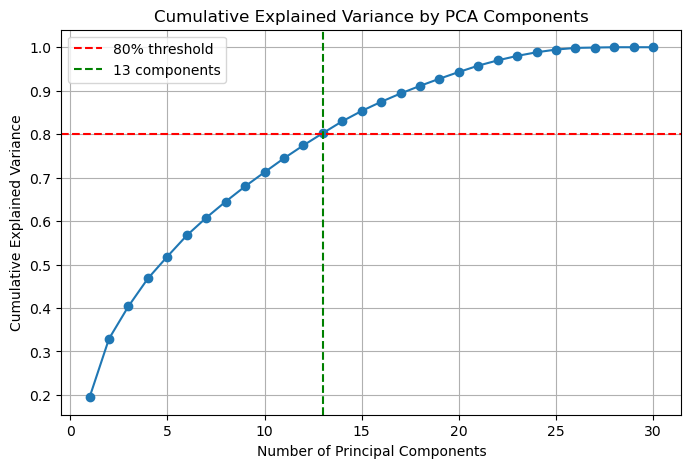

In [6]:
# Add principal components to DataFrame for plotting
allData['PC1'] = principal_components[:, 0]
allData['PC2'] = principal_components[:, 1]

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance (first 2 PCs):", np.sum(pca.explained_variance_ratio_))

# Fit PCA with all components
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Print how many components are needed for at least 80% explained variance
n_components_80 = np.argmax(cum_var >= 0.8) + 1
print(f"Number of components for at least 80% explained variance: {n_components_80}")

# Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='80% threshold')
plt.axvline(n_components_80, color='green', linestyle='--', label=f'{n_components_80} components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

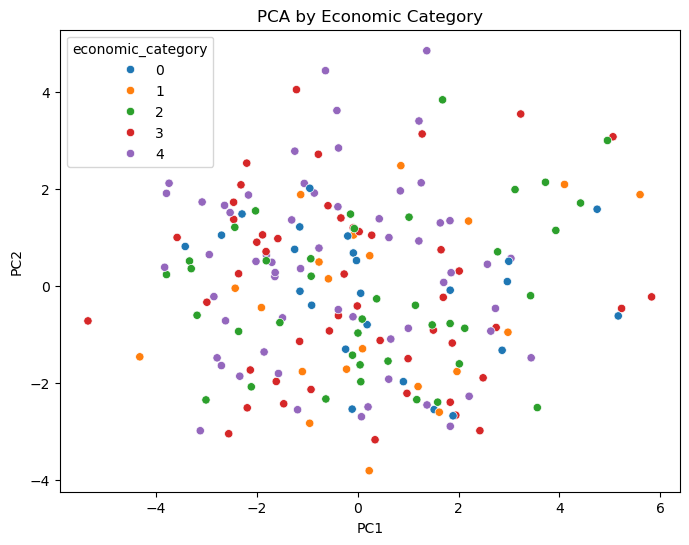

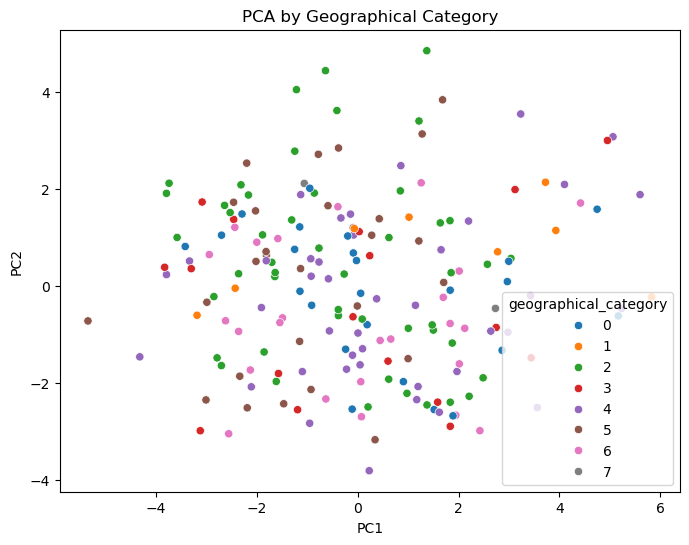

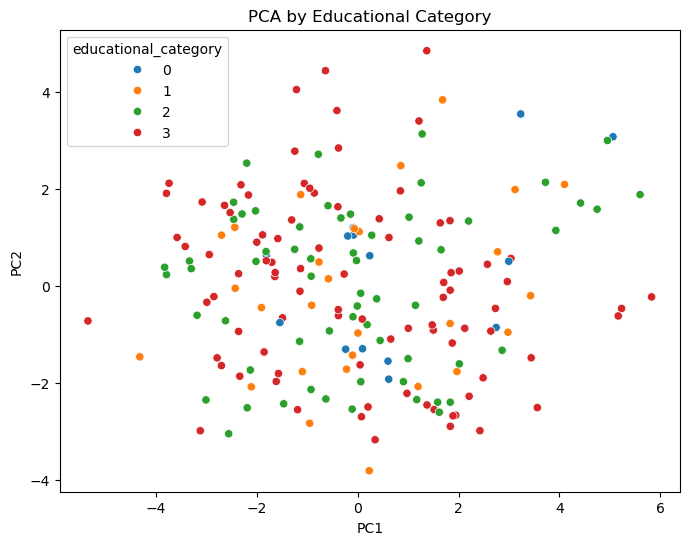

In [3]:
# Plot by economic category
plt.figure(figsize=(8,6))
sns.scatterplot(data=allData, x='PC1', y='PC2', hue='economic_category', palette='tab10')
plt.title('PCA by Economic Category')
plt.show()

# Plot by geographical category
plt.figure(figsize=(8,6))
sns.scatterplot(data=allData, x='PC1', y='PC2', hue='geographical_category', palette='tab10')
plt.title('PCA by Geographical Category')
plt.show()

# Plot by educational category
plt.figure(figsize=(8,6))
sns.scatterplot(data=allData, x='PC1', y='PC2', hue='educational_category', palette='tab10')
plt.title('PCA by Educational Category')
plt.show()

In [9]:
# Print unassigned countries for each category

print("Unassigned countries in economic_category:")
print(allData.loc[allData['economic_category'] == 0, 'country'].unique())
print(len(allData.loc[allData['economic_category'] == 0, 'country'].unique()), "countries unassigned in economic_category")

print("\nUnassigned countries in geographical_category:")
print(allData.loc[allData['geographical_category'] == 0, 'country'].unique())
print(len(allData.loc[allData['geographical_category'] == 0, 'country'].unique()), "countries unassigned in geographical_category")

print("\nUnassigned countries in educational_category:")
print(allData.loc[allData['educational_category'] == 0, 'country'].unique())
print(len(allData.loc[allData['educational_category'] == 0, 'country'].unique()), "countries unassigned in educational_category")

Unassigned countries in economic_category:
['Bolivia (Plurinational State of)' 'Congo' "Côte d'Ivoire"
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Egypt' 'Gambia' 'Guinea Bissau'
 'Iran (Islamic Republic of)' 'Kyrgyzstan'
 "Lao People's Democratic Republic" 'Micronesia (Federated States of)'
 'Netherlands (Kingdom of the)' 'Republic of Korea' 'Republic of Moldova'
 'Saint Kitts and Nevis' 'Saint Lucia' 'Saint Vincent and the Grenadines'
 'Sao Tome and Principe' 'Slovakia' 'United Republic of Tanzania'
 'Venezuela (Bolivarian Republic of)' 'Viet Nam' 'Yemen']
24 countries unassigned in economic_category

Unassigned countries in geographical_category:
['Bolivia (Plurinational State of)' 'Congo' "Côte d'Ivoire"
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Egypt' 'Gambia' 'Guinea Bissau'
 'Iran (Islamic Republic of)' 'Kyrgyzstan'
 "Lao People's Democratic Republic" 'Micronesia (Federated States of)'
 'Netherlands (Kingdom o